<a href="https://colab.research.google.com/github/EkaterinaVoloshina/classification_of_dative_semantic_roles/blob/main/notebooks/semi_supervised_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install --upgrade scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.2)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt
import random
from operator import itemgetter
import seaborn as sn
import xgboost as xgb
from torch import nn, optim
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_recall_curve, confusion_matrix, classification_report, f1_score
from sklearn.linear_model import LogisticRegression
import torch
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
! git clone 'https://github.com/EkaterinaVoloshina/classification_of_dative_semantic_roles/'

fatal: destination path 'classification_of_dative_semantic_roles' already exists and is not an empty directory.


In [ ]:
features = pd.read_csv('./classification_of_dative_semantic_roles/data/unannotated_data.csv')

le = LabelEncoder()
one = OneHotEncoder()

In [ ]:
features['prep'] = features['prep'].fillna(False)
features['dobj'] = features['dobj'].fillna(False)
features = features[features['d.lemma'].notna()]

In [ ]:
features = features.drop(['d.lemma', 's.lemma', 'v.lemma'], axis=1)

In [ ]:
features = features.drop(['Unnamed: 0', 'key'], axis=1)
features = features.fillna('none')
features = features.replace('no_subject', 'none')

In [ ]:
prep = features['prep'].astype(int)
dobj = features['dobj'].astype(int)
features = features.apply(le.fit_transform)

In [ ]:
data_w_answers = features[features['role'] != 0]
unlabeled = features[features['role'] == 0].drop('role', axis=1)
roles = le.fit_transform(data_w_answers['role'])

In [ ]:
def calculate_metrics(y_true, y_pred):
    print(f'Accuracy is {accuracy_score(y_true, y_pred)}')
    print(f'Macro F1-score is {f1_score(y_test, y_pred, average="macro")}')
    print(f'Micro F1-score is {f1_score(y_test, y_pred, average="micro")}')
    print(f'Classification report: {classification_report(y_test, y_pred)}')
    df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
    index = [i for i in le.classes_],
                  columns = [i for i in le.classes_])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)

In [ ]:
roles = data_w_answers['role']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_w_answers.index, roles)

In [ ]:
data = features.drop('role', axis=1).drop(X_test)
target = features['role'].drop(X_test)
target[target == 0] = -1

In [ ]:
one.fit(features.drop('role', axis=1))
one_data = one.transform(data)

OneHotEncoder()

Accuracy is 0.63671875
Macro F1-score is 0.5598511617008456
Micro F1-score is 0.63671875
Classification report:               precision    recall  f1-score   support

           1       0.46      0.38      0.42        58
           2       0.76      0.62      0.68        71
           3       0.86      0.74      0.79       102
           4       0.38      0.14      0.21        42
           5       0.59      0.82      0.69       174
           6       0.58      0.57      0.57        65

    accuracy                           0.64       512
   macro avg       0.60      0.54      0.56       512
weighted avg       0.63      0.64      0.62       512



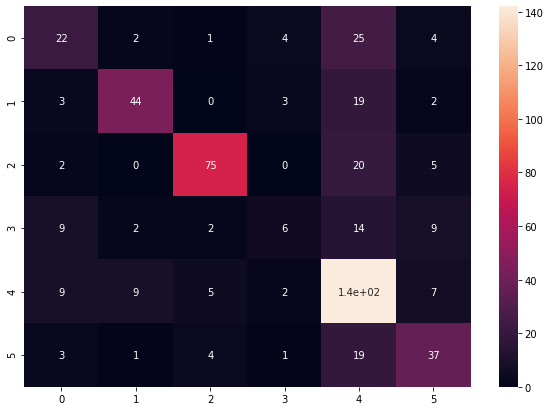

In [ ]:
lg = LogisticRegression(solver='sag')
lg.fit(one.transform(features.iloc[X_train].drop('role', axis=1)), y_train)
y_pred = lg.predict(one.transform(features.iloc[X_test].drop('role', axis=1)))
calculate_metrics(y_test, y_pred)

Accuracy is 0.62109375
Macro F1-score is 0.5206982099977794
Micro F1-score is 0.62109375
Classification report:               precision    recall  f1-score   support

           1       0.43      0.38      0.40        58
           2       0.67      0.56      0.61        71
           3       0.81      0.80      0.81       102
           4       0.12      0.02      0.04        42
           5       0.59      0.78      0.67       174
           6       0.62      0.57      0.59        65

    accuracy                           0.62       512
   macro avg       0.54      0.52      0.52       512
weighted avg       0.59      0.62      0.60       512



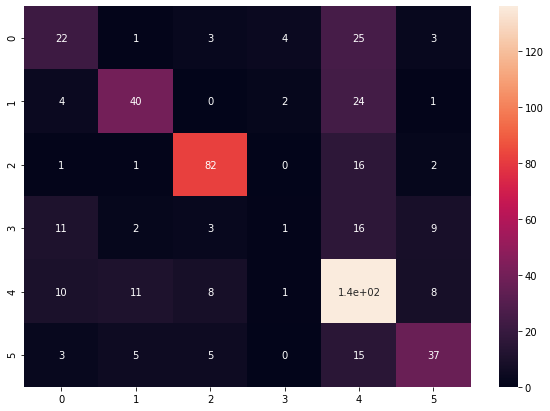

In [ ]:
stc = SelfTrainingClassifier(LogisticRegression(solver='sag'), threshold=0.7, max_iter=15)
stc.fit(one_data, target)
y_pred = stc.predict(one.transform(features.iloc[X_test].drop('role', axis=1)))
calculate_metrics(y_test, y_pred)

In [ ]:
from collections import Counter

Counter(stc.transduction_)

Counter({-1: 5673, 1: 7348, 2: 9439, 3: 21116, 4: 304, 5: 42186, 6: 8286})

In [ ]:
stc.termination_condition_

'max_iter'

Accuracy is 0.625
Macro F1-score is 0.5290944352930503
Micro F1-score is 0.625
Classification report:               precision    recall  f1-score   support

           1       0.65      0.22      0.33        58
           2       0.75      0.42      0.54        71
           3       0.83      0.74      0.78       102
           4       0.43      0.14      0.21        42
           5       0.54      0.91      0.68       174
           6       0.70      0.57      0.63        65

    accuracy                           0.62       512
   macro avg       0.65      0.50      0.53       512
weighted avg       0.65      0.62      0.60       512



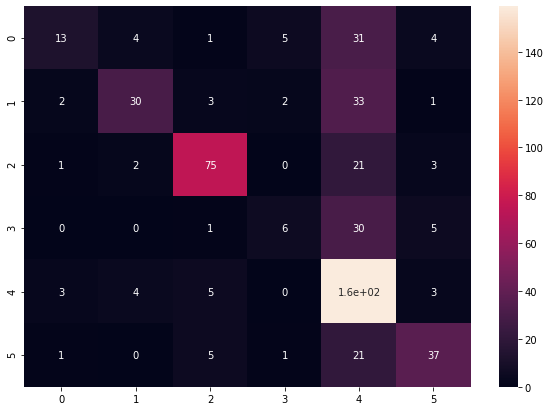

In [ ]:
lg = RandomForestClassifier(criterion='entropy', bootstrap=True, max_depth=8)
lg.fit(features.iloc[X_train].drop('role', axis=1), y_train)
y_pred = lg.predict(features.iloc[X_test].drop('role', axis=1))
calculate_metrics(y_test, y_pred)

Accuracy is 0.6015625
Macro F1-score is 0.49690384309049174
Micro F1-score is 0.6015625
Classification report:               precision    recall  f1-score   support

           1       0.71      0.21      0.32        58
           2       0.74      0.35      0.48        71
           3       0.78      0.72      0.74       102
           4       0.36      0.12      0.18        42
           5       0.52      0.91      0.67       174
           6       0.69      0.52      0.60        65

    accuracy                           0.60       512
   macro avg       0.63      0.47      0.50       512
weighted avg       0.63      0.60      0.57       512



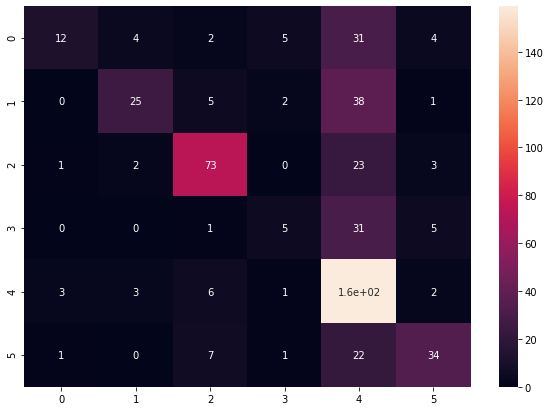

In [ ]:
stc_tree = SelfTrainingClassifier(RandomForestClassifier(criterion='entropy', bootstrap=True, max_depth=8), criterion='k_best', k_best=75, max_iter=25)
stc_tree.fit(data, target)
y_pred = stc_tree.predict(features.iloc[X_test].drop('role', axis=1))
calculate_metrics(y_test, y_pred)

Accuracy is 0.62890625
Macro F1-score is 0.5589971141284958
Micro F1-score is 0.62890625
Classification report:               precision    recall  f1-score   support

           1       0.53      0.31      0.39        58
           2       0.78      0.51      0.62        71
           3       0.81      0.77      0.79       102
           4       0.56      0.21      0.31        42
           5       0.55      0.83      0.66       174
           6       0.64      0.54      0.58        65

    accuracy                           0.63       512
   macro avg       0.64      0.53      0.56       512
weighted avg       0.64      0.63      0.61       512



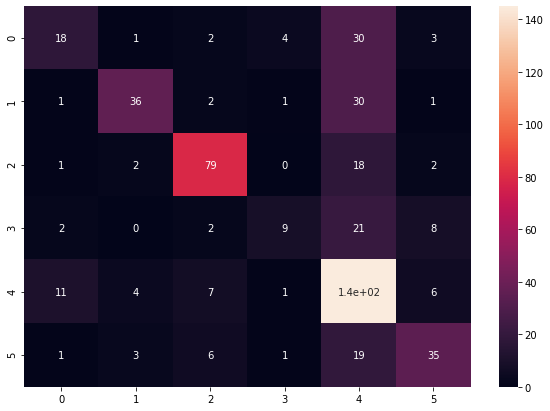

In [ ]:
clf_r = xgb.XGBClassifier(n_estimators=1000, learning_rate=1e-2, max_depth=3, silent=True)
clf_r.fit(features.iloc[X_train].drop('role', axis=1), y_train)
y_pred = clf_r.predict(features.iloc[X_test].drop('role', axis=1))
calculate_metrics(y_test, y_pred)

Accuracy is 0.623046875
Macro F1-score is 0.5542682782209708
Micro F1-score is 0.623046875
Classification report:               precision    recall  f1-score   support

           1       0.50      0.31      0.38        58
           2       0.77      0.52      0.62        71
           3       0.79      0.77      0.78       102
           4       0.50      0.21      0.30        42
           5       0.55      0.82      0.66       174
           6       0.65      0.52      0.58        65

    accuracy                           0.62       512
   macro avg       0.63      0.53      0.55       512
weighted avg       0.63      0.62      0.61       512



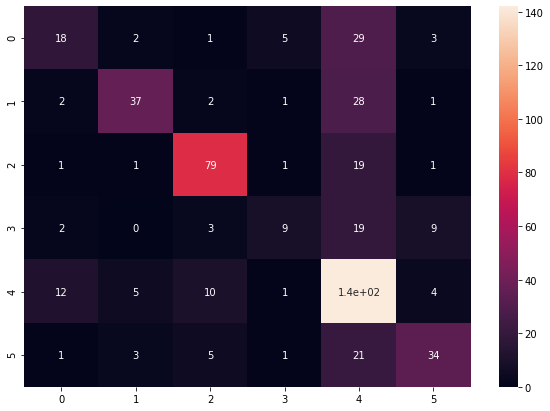

In [ ]:
slc_boost = SelfTrainingClassifier(xgb.XGBClassifier(n_estimators=1000, learning_rate=1e-2, max_depth=3, silent=True), criterion='k_best', k_best=80, max_iter=30)
slc_boost.fit(data, target)
y_pred = slc_boost.predict(features.iloc[X_test].drop('role', axis=1).to_numpy())
calculate_metrics(y_test, y_pred)

In [ ]:
y_pred = slc_boost.predict(features.iloc[X_test].drop('role', axis=1))
calculate_metrics(y_test, y_pred)